In [1]:
pip install pandas matplotlib seaborn openpiyxl

Looking in indexes: http://em-nexus-1.main.oecd.org:8081/repository/pip-group-proxy/simple/
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement openpiyxl (from versions: none)
ERROR: No matching distribution found for openpiyxl


In [2]:
# Import necessary Python libraries
import pandas as pd

# Load the dataset from OECD STIP Survey with error handling
url = "https://stip.oecd.org/assets/downloads/STIP_Survey.xlsx"
stip_survey = pd.read_excel(url, engine="openpyxl")
print("Data loaded successfully!")
# Display basic information about the dataset
print("\nNumber of rows in the dataset:", len(stip_survey))
print("\nFirst 5 rows of the dataset:")
display(stip_survey.head())
display(stip_survey.count())

Data loaded successfully!

Number of rows in the dataset: 12660

First 5 rows of the dataset:


,InitiativeID,SurveyYear,CreatedInSurvey,LastModifiedInSurvey,NameEnglish,CountryLabel,CountryCode,NameOriginalLanguage,Acronym,StartDateYear,...,F9:V294,F9:V295,F98:V670,F98:V671,F98:V672,F98:V673,F99:V674,F99:V675,F99:V676,F99:V677
0,Policy Initiative URI,Year of the survey,Creation date in the survey,Last modification date in the survey,English name,Country name,Country code,Name in original language,Acronym,Start year,...,Debt guarantees and risk sharing schemes:Claim...,Debt guarantees and risk sharing schemes:Claim...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...
1,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,1,0,0,0,0,0,1
2,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,0,0,0,0,0,0,0
3,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:36:36Z,2025-08-11T15:05:54Z,CORE,Luxembourg,LUX,NaN,NaN,2007,...,0,0,0,0,0,0,0,0,0,0
4,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T14:20:00Z,2025-08-11T15:05:54Z,Open Access Fund,Luxembourg,LUX,Open Access Fund,NaN,2017,...,0,0,0,0,0,0,0,0,0,0


InitiativeID            12660
SurveyYear              12660
CreatedInSurvey         12660
LastModifiedInSurvey    12660
NameEnglish             12638
                        ...  
F98:V673                12660
F99:V674                12660
F99:V675                12660
F99:V676                12660
F99:V677                12660
Length: 519, dtype: int64

In [3]:
#To facilitate working with the dataset, we generate a separate 'Codebook' dataframe listing the column names and the detail given in the first row, for variables on themes and direct beneficiaries

# 1. Get column names (Code) and the first row (Meaning) from the DataFrame
columns = stip_survey.columns
meanings = stip_survey.iloc[0].values

# 2. Create a DataFrame pairing each column name with its description
codebook = pd.DataFrame({
    "Code": columns,
    "Meaning": meanings
})

# 3. Filter only columns whose names start with "TH" or "TG" (policy themes and direct beneficiaries)
codebook = codebook[codebook["Code"].str.match(r"^TH|^TG")].reset_index(drop=True)

# 4. Display the first 10 rows of the codebook
print("First 5 rows of the codebook:")
print(codebook.head(5))



First 5 rows of the codebook:
    Code                                            Meaning
0  TH101                Net zero transitions policy debates
1  TH102   Government capabilities for net zero transitions
2  TH103     Net zero transitions in transport and mobility
3  TH104       Net zero transitions in food and agriculture
4  TH106  Digital transformation of research-performing ...


In [4]:
# Remove duplicates of policy initiatives
stip_survey_unique = stip_survey.drop_duplicates(subset=["InitiativeID"]).copy()
print(f"Original data rows: {len(stip_survey)}")
print(f"Unique initiatives: {len(stip_survey_unique)}")
print(stip_survey_unique.head())


Original data rows: 12660
Unique initiatives: 8716
                                        InitiativeID          SurveyYear  \
0                              Policy Initiative URI  Year of the survey   
1  http://stip.oecd.org/2025/data/policyInitiativ...                2025   
3  http://stip.oecd.org/2025/data/policyInitiativ...                2025   
4  http://stip.oecd.org/2025/data/policyInitiativ...                2025   
6  http://stip.oecd.org/2025/data/policyInitiativ...                2025   

               CreatedInSurvey                  LastModifiedInSurvey  \
0  Creation date in the survey  Last modification date in the survey   
1         2017-07-31T12:11:38Z                  2025-08-11T15:05:53Z   
3         2017-07-31T12:36:36Z                  2025-08-11T15:05:54Z   
4         2017-07-31T14:20:00Z                  2025-08-11T15:05:54Z   
6         2017-07-31T14:40:34Z                  2025-08-11T15:05:55Z   

                        NameEnglish  CountryLabel   Country

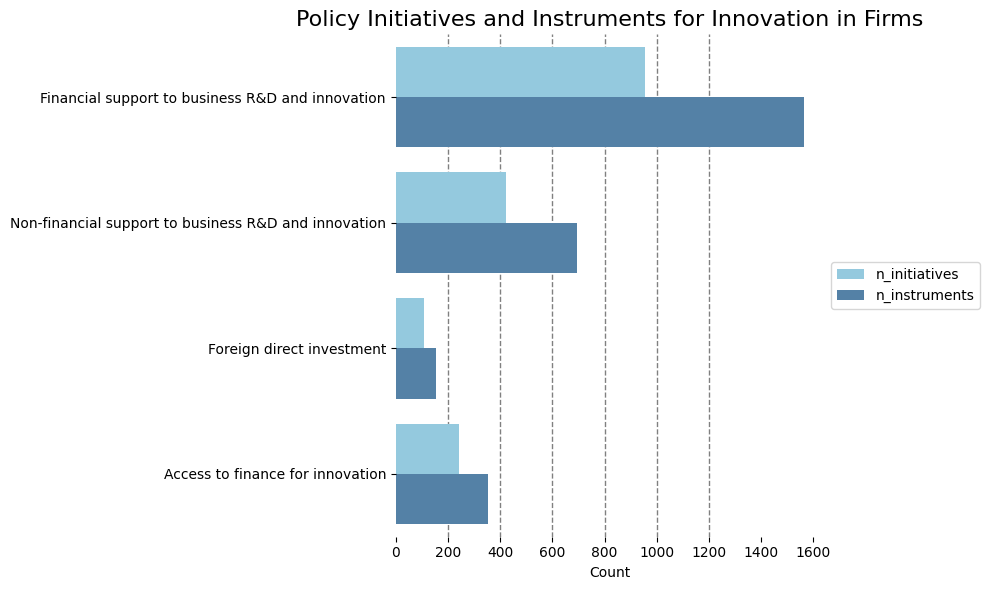

In [5]:

# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Remove columns that start with "F" (make a copy to avoid SettingWithCopyWarning) ---
financing_innovation = stip_survey.loc[:, ~stip_survey.columns.str.startswith('F')].copy()

# --- 2. Filter rows where at least one of the target themes is present ---
theme_cols = ['TH31', 'TH32', 'TH36', 'TH38']
# Ensure theme columns are numeric
financing_innovation[theme_cols] = financing_innovation[theme_cols].apply(pd.to_numeric, errors='coerce')
# Keep rows where the sum of these columns is greater than 0
financing_innovation = financing_innovation[financing_innovation[theme_cols].sum(axis=1) > 0]

# --- 3. Reshape to long format for the four themes ---
financing_long = financing_innovation.melt(
    id_vars=[col for col in financing_innovation.columns if col not in theme_cols],
    value_vars=theme_cols,
    var_name='Theme',
    value_name='value'
)
# Keep only rows where the theme is present (value == 1)
financing_long = financing_long[financing_long['value'] == 1]

# --- 4. Count the number of instruments per InitiativeID and Theme ---
grouped = financing_long.groupby(['InitiativeID', 'Theme']).size().reset_index(name='n_instruments')

# --- 5. For each Theme, keep only unique InitiativeID and summarize ---
unique_initiatives = grouped.drop_duplicates(subset=['Theme', 'InitiativeID'])
summary = unique_initiatives.groupby('Theme').agg(
    n_initiatives=('InitiativeID', 'nunique'),
    n_instruments=('n_instruments', 'sum')
).reset_index()
# --- 6. Map theme codes to descriptive labels for plotting ---
theme_labels = {
    'TH31': 'Financial support to business R&D and innovation',
    'TH32': 'Non-financial support to business R&D and innovation',
    'TH36': 'Foreign direct investment',
    'TH38': 'Access to finance for innovation'
}
summary['Theme_label'] = summary['Theme'].map(theme_labels)

# --- 7. Reshape summary for plotting (long format) ---
plot_df = pd.melt(
    summary,
    id_vars='Theme_label',
    value_vars=['n_initiatives', 'n_instruments'],
    var_name='Type',
    value_name='Count'
)

# --- 8. Plot grouped horizontal bar chart ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    y='Theme_label',
    x='Count',
    hue='Type',
    palette=['skyblue', 'steelblue']
)
for x in [200, 400, 600, 800, 1000,1200]:
    plt.axvline(x, color='gray', linestyle='--', lw=1, zorder=0)
sns.despine(left=True, bottom=True)

plt.title('Policy Initiatives and Instruments for Innovation in Firms', fontsize=16)
plt.xlabel('Count')
plt.ylabel('')
plt.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

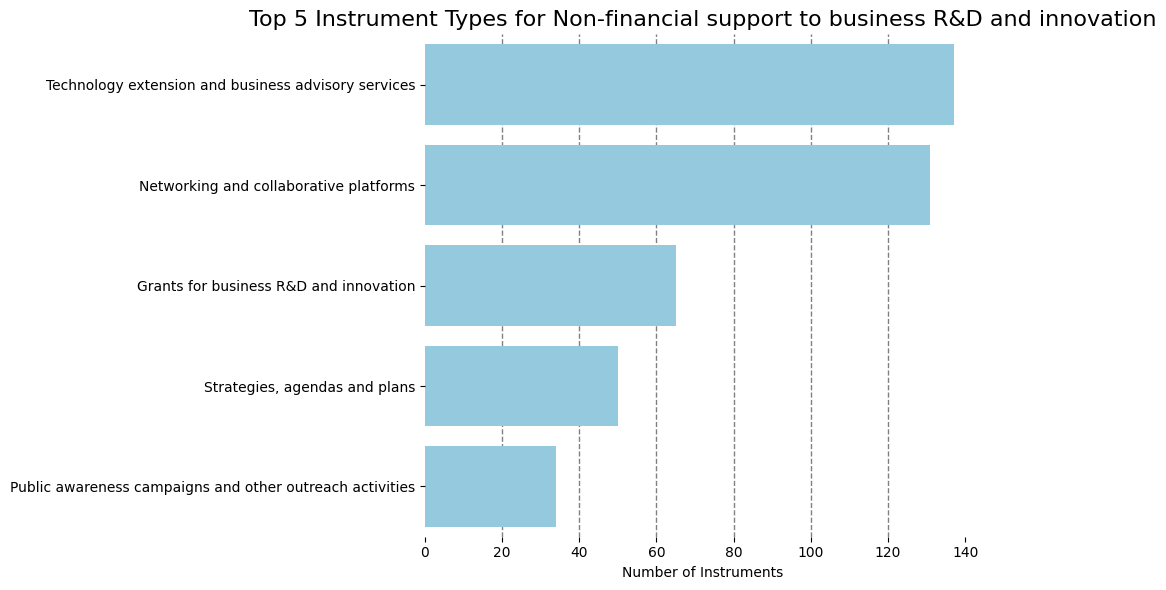

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Remove columns that start with "F"
th32_instruments = stip_survey.loc[:, ~stip_survey.columns.str.startswith('F')]

# 2. Filter rows where TH32 > 0 (ignore non-numeric rows)
th32_instruments = th32_instruments[
    pd.to_numeric(th32_instruments['TH32'], errors='coerce') > 0
]

# 3. Group by 'InstrumentTypeLabel' and count occurrences
th32_instruments = (
    th32_instruments
    .groupby('InstrumentTypeLabel')
    .size()
    .reset_index(name='n')
)

# 4. Get the top 5 by count, descending order
th32_instruments = th32_instruments.nlargest(5, 'n').sort_values('n', ascending=False)

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=th32_instruments,
    y='InstrumentTypeLabel',
    x='n',
    color='skyblue'
)
for x in [20, 40, 60, 80, 100,120]:
    plt.axvline(x, color='gray', linestyle='--', lw=1, zorder=0)
sns.despine(left=True, bottom=True)
plt.title('Top 5 Instrument Types for Non-financial support to business R&D and innovation', fontsize=16)
plt.xlabel('Number of Instruments')

plt.ylabel('')
plt.tight_layout()
plt.show()

In [7]:
# Analysis of Target Groups (TG columns) and Policy Instruments (F-numbered columns)
# Based on the STIP Survey data structure description

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=== STIP Survey Data Structure Analysis ===\n")

# 1. Analyze Target Groups (TG columns)
print("1. TARGET GROUPS ANALYSIS")
print("-" * 40)

# Get all TG columns
tg_columns = [col for col in stip_survey.columns if col.startswith('TG')]
print(f"Number of target group columns: {len(tg_columns)}")

# Create codebook for target groups
tg_codebook = pd.DataFrame({
    "Code": tg_columns,
    "Meaning": [stip_survey[col].iloc[0] for col in tg_columns]
})

print(f"\nFirst 10 target groups:")
print(tg_codebook.head(10))

# Count initiatives by target group (excluding header row)
tg_data = stip_survey.iloc[1:][tg_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
tg_counts = tg_data.sum().sort_values(ascending=False)

print(f"\nTop 10 most common target groups:")
for i, (tg_code, count) in enumerate(tg_counts.head(10).items()):
    meaning = tg_codebook[tg_codebook['Code'] == tg_code]['Meaning'].iloc[0]
    print(f"{i+1:2d}. {tg_code}: {count:4d} initiatives - {meaning}")


=== STIP Survey Data Structure Analysis ===

1. TARGET GROUPS ANALYSIS
----------------------------------------
Number of target group columns: 34

First 10 target groups:
   Code                                      Meaning
0  TG10            Undergraduate and master students
1  TG11  Postdocs and other early-career researchers
2  TG12                                 PhD students
3  TG13                                     Teachers
4  TG14                                        Women
5  TG15            Disadvantaged and excluded groups
6  TG16                                Civil society
7  TG17                            Private investors
8  TG18                                Entrepreneurs
9  TG19                      Labour force in general

Top 10 most common target groups:
 1. TG21: 6438 initiatives - Public research institutes
 2. TG20: 6299 initiatives - Higher education institutes
 3. TG29: 4676 initiatives - Firms of any size
 4. TG9: 4278 initiatives - Established researcher

In [8]:
# 2. Analyze Policy Instruments (F-numbered columns)
print("\n2. POLICY INSTRUMENTS ANALYSIS")
print("-" * 40)

# Get all F-numbered columns
f_columns = [col for col in stip_survey.columns if col.startswith('F')]
print(f"Number of policy instrument facet columns: {len(f_columns)}")

# Get unique instrument types
instrument_types = stip_survey['InstrumentTypeLabel'].iloc[1:].value_counts()
print(f"\nNumber of unique instrument types: {len(instrument_types)}")
print(f"\nTop 10 most common instrument types:")
for i, (instrument, count) in enumerate(instrument_types.head(10).items()):
    print(f"{i+1:2d}. {instrument}: {count:4d} instruments")

# Analyze F-column structure
print(f"\nF-column structure analysis:")
f_column_patterns = {}
for col in f_columns:
    if ':' in col:
        prefix = col.split(':')[0]
        if prefix not in f_column_patterns:
            f_column_patterns[prefix] = 0
        f_column_patterns[prefix] += 1

print(f"Number of F-column prefixes: {len(f_column_patterns)}")
print(f"Top 10 F-column prefixes:")
for i, (prefix, count) in enumerate(sorted(f_column_patterns.items(), key=lambda x: x[1], reverse=True)[:10]):
    print(f"{i+1:2d}. {prefix}: {count:3d} columns")



2. POLICY INSTRUMENTS ANALYSIS
----------------------------------------
Number of policy instrument facet columns: 383

Number of unique instrument types: 28

Top 10 most common instrument types:
 1. Strategies, agendas and plans: 2322 instruments
 2. Project grants for public research: 1325 instruments
 3. Grants for business R&D and innovation: 1163 instruments
 4. Networking and collaborative platforms:  953 instruments
 5. Public awareness campaigns and other outreach activities:  669 instruments
 6. Policy intelligence (e.g. evaluations, benchmarking and forecasts):  598 instruments
 7. Creation or reform of governance structure or public body:  550 instruments
 8. Institutional funding for public research:  486 instruments
 9. Information services and access to datasets:  448 instruments
10. Fellowships and postgraduate loans and scholarships:  425 instruments

F-column structure analysis:
Number of F-column prefixes: 70
Top 10 F-column prefixes:
 1. F58:  20 columns
 2. F21:  1


3. VISUALIZATIONS
----------------------------------------


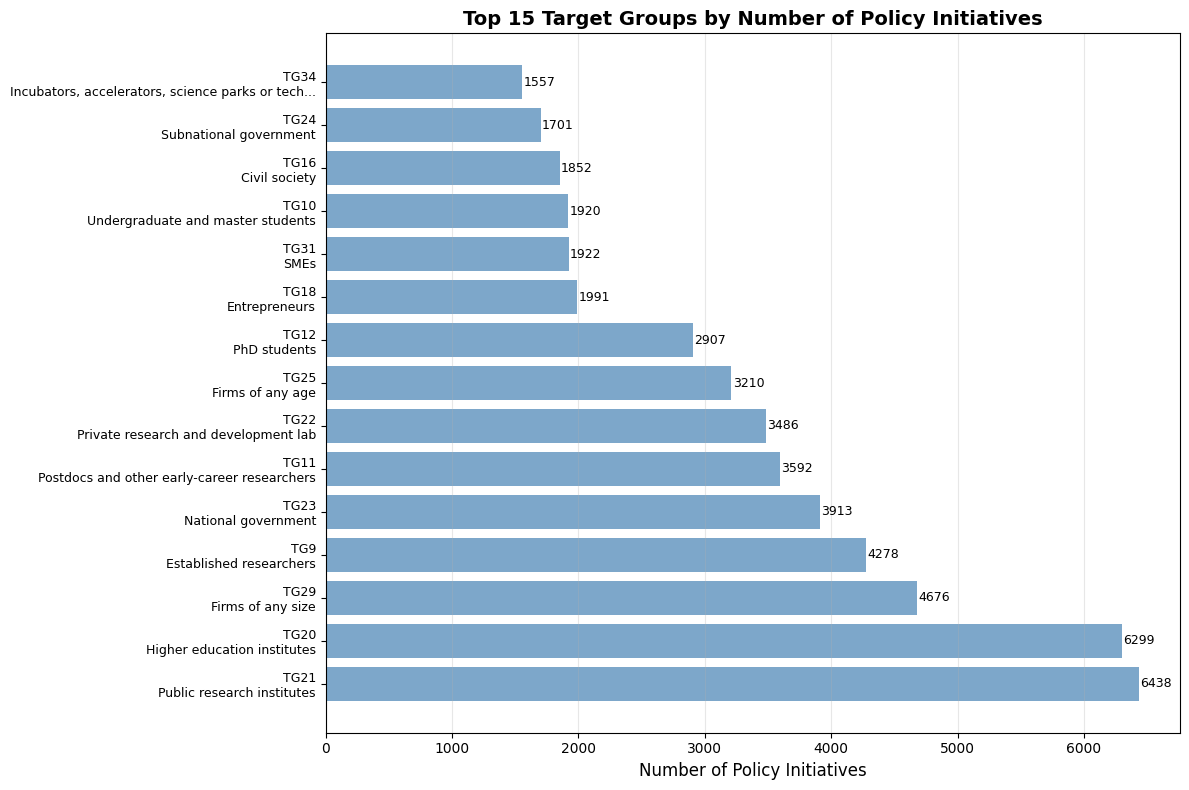

Total initiatives covered by top 15 target groups: 49,742
Percentage of total initiatives: 76.3%


In [9]:
# 3. Visualization: Target Groups Distribution
print("\n3. VISUALIZATIONS")
print("-" * 40)

# Create visualization for top target groups
plt.figure(figsize=(12, 8))

# Top 15 target groups
top_tg = tg_counts.head(15)
tg_labels = []
for tg_code in top_tg.index:
    meaning = tg_codebook[tg_codebook['Code'] == tg_code]['Meaning'].iloc[0]
    # Truncate long labels for better display
    if len(meaning) > 50:
        meaning = meaning[:47] + "..."
    tg_labels.append(f"{tg_code}\n{meaning}")

# Create horizontal bar plot
bars = plt.barh(range(len(top_tg)), top_tg.values, color='steelblue', alpha=0.7)
plt.yticks(range(len(top_tg)), tg_labels, fontsize=9)
plt.xlabel('Number of Policy Initiatives', fontsize=12)
plt.title('Top 15 Target Groups by Number of Policy Initiatives', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_tg.values)):
    plt.text(value + 10, bar.get_y() + bar.get_height()/2, 
             f'{int(value)}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total initiatives covered by top 15 target groups: {top_tg.sum():,}")
print(f"Percentage of total initiatives: {(top_tg.sum() / tg_counts.sum() * 100):.1f}%")


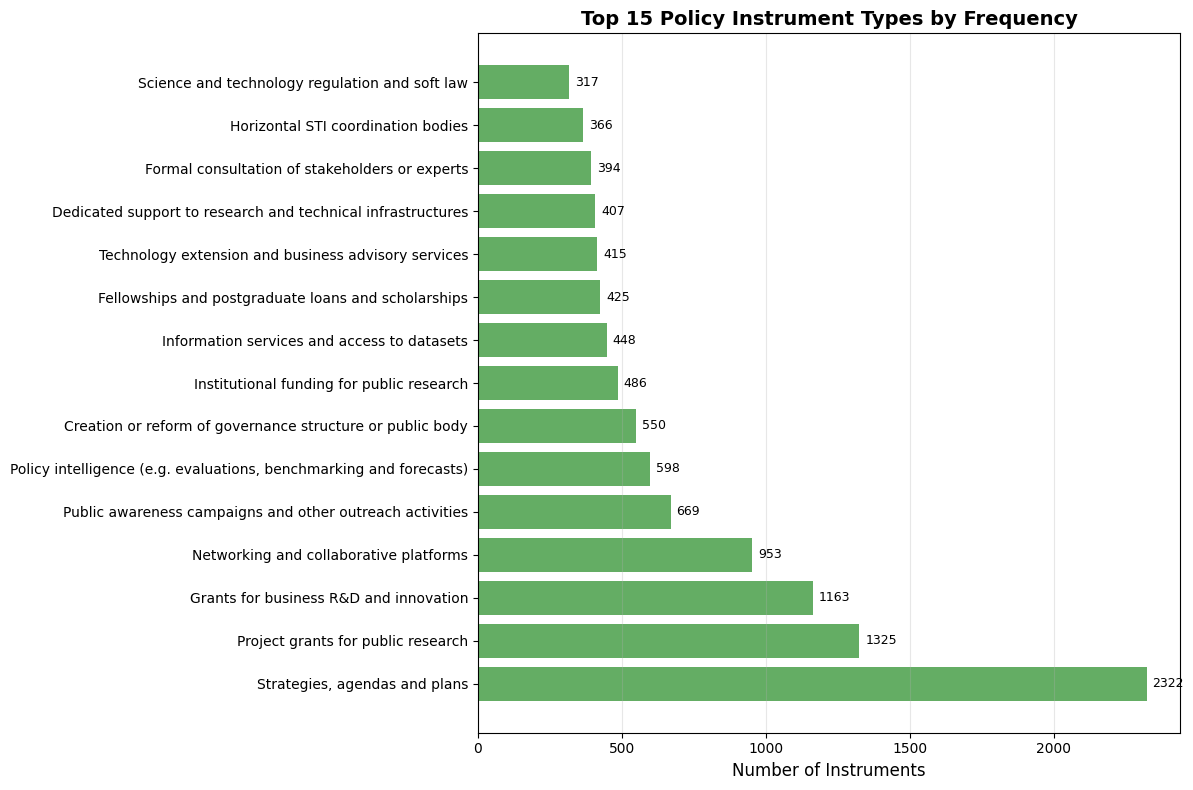

Total instruments covered by top 15 types: 10,838
Percentage of total instruments: 86.2%


In [10]:
# 4. Visualization: Policy Instrument Types Distribution
plt.figure(figsize=(12, 8))

# Top 15 instrument types
top_instruments = instrument_types.head(15)

# Create horizontal bar plot
bars = plt.barh(range(len(top_instruments)), top_instruments.values, color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_instruments)), top_instruments.index, fontsize=10)
plt.xlabel('Number of Instruments', fontsize=12)
plt.title('Top 15 Policy Instrument Types by Frequency', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_instruments.values)):
    plt.text(value + 20, bar.get_y() + bar.get_height()/2, 
             f'{int(value)}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total instruments covered by top 15 types: {top_instruments.sum():,}")
print(f"Percentage of total instruments: {(top_instruments.sum() / instrument_types.sum() * 100):.1f}%")


In [11]:
# 5. Cross-analysis: Target Groups vs Policy Instruments
print("\n5. CROSS-ANALYSIS: TARGET GROUPS AND POLICY INSTRUMENTS")
print("-" * 60)

# Analyze relationship between target groups and instrument types
# Get data without header row
analysis_data = stip_survey.iloc[1:].copy()

# Convert TG columns to numeric
tg_cols = [col for col in analysis_data.columns if col.startswith('TG')]
analysis_data[tg_cols] = analysis_data[tg_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Create a summary of initiatives by target group and instrument type
cross_analysis = []

for tg_col in tg_cols[:10]:  # Analyze top 10 target groups
    tg_name = tg_codebook[tg_codebook['Code'] == tg_col]['Meaning'].iloc[0]
    
    # Get initiatives for this target group
    tg_initiatives = analysis_data[analysis_data[tg_col] == 1]
    
    if len(tg_initiatives) > 0:
        # Get top instrument types for this target group
        top_instruments = tg_initiatives['InstrumentTypeLabel'].value_counts().head(3)
        
        for instrument, count in top_instruments.items():
            cross_analysis.append({
                'Target_Group': tg_col,
                'Target_Group_Name': tg_name[:50] + "..." if len(tg_name) > 50 else tg_name,
                'Instrument_Type': instrument,
                'Count': count,
                'Percentage': (count / len(tg_initiatives)) * 100
            })

cross_df = pd.DataFrame(cross_analysis)

print("Top instrument types for each target group:")
for tg in cross_df['Target_Group'].unique():
    tg_data = cross_df[cross_df['Target_Group'] == tg]
    tg_name = tg_data['Target_Group_Name'].iloc[0]
    print(f"\n{tg} - {tg_name}")
    for _, row in tg_data.iterrows():
        print(f"  • {row['Instrument_Type']}: {row['Count']} ({row['Percentage']:.1f}%)")



5. CROSS-ANALYSIS: TARGET GROUPS AND POLICY INSTRUMENTS
------------------------------------------------------------
Top instrument types for each target group:

TG10 - Undergraduate and master students
  • Strategies, agendas and plans: 355 (18.5%)
  • Public awareness campaigns and other outreach activities: 192 (10.0%)
  • Networking and collaborative platforms: 167 (8.7%)

TG11 - Postdocs and other early-career researchers
  • Strategies, agendas and plans: 582 (16.2%)
  • Project grants for public research: 565 (15.7%)
  • Networking and collaborative platforms: 285 (7.9%)

TG12 - PhD students
  • Strategies, agendas and plans: 505 (17.4%)
  • Project grants for public research: 375 (12.9%)
  • Fellowships and postgraduate loans and scholarships: 248 (8.5%)

TG13 - Teachers
  • Strategies, agendas and plans: 256 (22.8%)
  • Public awareness campaigns and other outreach activities: 192 (17.1%)
  • Networking and collaborative platforms: 97 (8.6%)

TG14 - Women
  • Strategies, agen

In [12]:
# FIXED VERSION - Load the dataset from OECD STIP Survey
# This cell replaces any problematic CSV loading cells

import pandas as pd

# Load the dataset from OECD STIP Survey with error handling
url = "https://stip.oecd.org/assets/downloads/STIP_Survey.xlsx"
stip_survey = pd.read_excel(url, engine="openpyxl", dtype=str)
print("Data loaded successfully!")
# Display basic information about the dataset
print("\nNumber of rows in the dataset:", len(stip_survey))
print("\nFirst 5 rows of the dataset:")
display(stip_survey.head())
display(stip_survey.count())


Data loaded successfully!

Number of rows in the dataset: 12660

First 5 rows of the dataset:


,InitiativeID,SurveyYear,CreatedInSurvey,LastModifiedInSurvey,NameEnglish,CountryLabel,CountryCode,NameOriginalLanguage,Acronym,StartDateYear,...,F9:V294,F9:V295,F98:V670,F98:V671,F98:V672,F98:V673,F99:V674,F99:V675,F99:V676,F99:V677
0,Policy Initiative URI,Year of the survey,Creation date in the survey,Last modification date in the survey,English name,Country name,Country code,Name in original language,Acronym,Start year,...,Debt guarantees and risk sharing schemes:Claim...,Debt guarantees and risk sharing schemes:Claim...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...
1,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,1,0,0,0,0,0,1
2,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,0,0,0,0,0,0,0
3,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:36:36Z,2025-08-11T15:05:54Z,CORE,Luxembourg,LUX,NaN,NaN,2007,...,0,0,0,0,0,0,0,0,0,0
4,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T14:20:00Z,2025-08-11T15:05:54Z,Open Access Fund,Luxembourg,LUX,Open Access Fund,NaN,2017,...,0,0,0,0,0,0,0,0,0,0


InitiativeID            12660
SurveyYear              12660
CreatedInSurvey         12660
LastModifiedInSurvey    12660
NameEnglish             12638
                        ...  
F98:V673                12660
F99:V674                12660
F99:V675                12660
F99:V676                12660
F99:V677                12660
Length: 519, dtype: int64

In [13]:
# COMPLETE SOLUTION - Run this cell to ensure all data is loaded correctly
# This cell will override any previous data loading issues

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clear any previous data loading issues
try:
    del stip_survey
except:
    pass

# Load the dataset from OECD STIP Survey with proper error handling
url = "https://stip.oecd.org/assets/downloads/STIP_Survey.xlsx"
stip_survey = pd.read_excel(url, engine="openpyxl", dtype=str)

print("✅ Data loaded successfully!")
print(f"📊 Dataset shape: {stip_survey.shape}")
print(f"📋 Columns: {len(stip_survey.columns)}")
print(f"📝 Rows: {len(stip_survey)}")

# Display basic information
print("\n🔍 First 5 rows:")
display(stip_survey.head())

print("\n📈 Column counts:")
display(stip_survey.count().head(10))

# Verify the data structure
tg_columns = [col for col in stip_survey.columns if col.startswith('TG')]
f_columns = [col for col in stip_survey.columns if col.startswith('F')]
th_columns = [col for col in stip_survey.columns if col.startswith('TH')]

print(f"\n🎯 Target Groups (TG): {len(tg_columns)} columns")
print(f"🔧 Policy Instruments (F): {len(f_columns)} columns") 
print(f"📋 Themes (TH): {len(th_columns)} columns")

print("\n✅ All data loaded correctly! You can now run the analysis cells.")


✅ Data loaded successfully!
📊 Dataset shape: (12660, 519)
📋 Columns: 519
📝 Rows: 12660

🔍 First 5 rows:


,InitiativeID,SurveyYear,CreatedInSurvey,LastModifiedInSurvey,NameEnglish,CountryLabel,CountryCode,NameOriginalLanguage,Acronym,StartDateYear,...,F9:V294,F9:V295,F98:V670,F98:V671,F98:V672,F98:V673,F99:V674,F99:V675,F99:V676,F99:V677
0,Policy Initiative URI,Year of the survey,Creation date in the survey,Last modification date in the survey,English name,Country name,Country code,Name in original language,Acronym,Start year,...,Debt guarantees and risk sharing schemes:Claim...,Debt guarantees and risk sharing schemes:Claim...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...
1,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,1,0,0,0,0,0,1
2,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,0,0,0,0,0,0,0
3,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:36:36Z,2025-08-11T15:05:54Z,CORE,Luxembourg,LUX,NaN,NaN,2007,...,0,0,0,0,0,0,0,0,0,0
4,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T14:20:00Z,2025-08-11T15:05:54Z,Open Access Fund,Luxembourg,LUX,Open Access Fund,NaN,2017,...,0,0,0,0,0,0,0,0,0,0



📈 Column counts:


InitiativeID            12660
SurveyYear              12660
CreatedInSurvey         12660
LastModifiedInSurvey    12660
NameEnglish             12638
CountryLabel            12660
CountryCode             12660
NameOriginalLanguage     9065
Acronym                  5743
StartDateYear           12425
dtype: int64


🎯 Target Groups (TG): 34 columns
🔧 Policy Instruments (F): 383 columns
📋 Themes (TH): 54 columns

✅ All data loaded correctly! You can now run the analysis cells.


In [14]:
# FIXED VERSION - Load the dataset from OECD STIP Survey
# This cell replaces any problematic CSV loading cells

import pandas as pd

# Load the dataset from OECD STIP Survey with error handling
url = "https://stip.oecd.org/assets/downloads/STIP_Survey.xlsx"
stip_survey = pd.read_excel(url, engine="openpyxl", dtype=str)
print("Data loaded successfully!")
# Display basic information about the dataset
print("\nNumber of rows in the dataset:", len(stip_survey))
print("\nFirst 5 rows of the dataset:")
display(stip_survey.head())
display(stip_survey.count())


Data loaded successfully!

Number of rows in the dataset: 12660

First 5 rows of the dataset:


,InitiativeID,SurveyYear,CreatedInSurvey,LastModifiedInSurvey,NameEnglish,CountryLabel,CountryCode,NameOriginalLanguage,Acronym,StartDateYear,...,F9:V294,F9:V295,F98:V670,F98:V671,F98:V672,F98:V673,F99:V674,F99:V675,F99:V676,F99:V677
0,Policy Initiative URI,Year of the survey,Creation date in the survey,Last modification date in the survey,English name,Country name,Country code,Name in original language,Acronym,Start year,...,Debt guarantees and risk sharing schemes:Claim...,Debt guarantees and risk sharing schemes:Claim...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum gra...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...,Project grants for public research:Maximum amo...
1,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,1,0,0,0,0,0,1
2,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:11:38Z,2025-08-11T15:05:53Z,INTER,Luxembourg,LUX,NaN,NaN,2006,...,0,0,0,0,0,0,0,0,0,0
3,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T12:36:36Z,2025-08-11T15:05:54Z,CORE,Luxembourg,LUX,NaN,NaN,2007,...,0,0,0,0,0,0,0,0,0,0
4,http://stip.oecd.org/2025/data/policyInitiativ...,2025,2017-07-31T14:20:00Z,2025-08-11T15:05:54Z,Open Access Fund,Luxembourg,LUX,Open Access Fund,NaN,2017,...,0,0,0,0,0,0,0,0,0,0


InitiativeID            12660
SurveyYear              12660
CreatedInSurvey         12660
LastModifiedInSurvey    12660
NameEnglish             12638
                        ...  
F98:V673                12660
F99:V674                12660
F99:V675                12660
F99:V676                12660
F99:V677                12660
Length: 519, dtype: int64

In [15]:
# 6. Summary Statistics and Data Structure Insights
print("\n6. SUMMARY STATISTICS AND INSIGHTS")
print("-" * 50)

# Basic dataset statistics
total_initiatives = len(stip_survey_unique)
total_instruments = len(stip_survey.iloc[1:])  # Excluding header row
total_tg_types = len(tg_columns)
total_instrument_types = len(instrument_types)
total_f_columns = len(f_columns)

print(f"Dataset Overview:")
print(f"  • Total unique policy initiatives: {total_initiatives:,}")
print(f"  • Total policy instruments: {total_instruments:,}")
print(f"  • Target group types (TG columns): {total_tg_types}")
print(f"  • Policy instrument types: {total_instrument_types}")
print(f"  • Instrument facet columns (F columns): {total_f_columns:,}")

# Calculate average instruments per initiative
avg_instruments_per_initiative = total_instruments / total_initiatives
print(f"  • Average instruments per initiative: {avg_instruments_per_initiative:.1f}")

# Target group coverage
initiatives_with_tg = (tg_data.sum(axis=1) > 0).sum()
tg_coverage = (initiatives_with_tg / len(tg_data)) * 100
print(f"  • Initiatives with target groups: {initiatives_with_tg:,} ({tg_coverage:.1f}%)")

# Most common target group combinations
print(f"\nTarget Group Analysis:")
tg_combinations = tg_data.sum(axis=1).value_counts().head(5)
print(f"Most common number of target groups per initiative:")
for num_tg, count in tg_combinations.items():
    percentage = (count / len(tg_data)) * 100
    print(f"  • {int(num_tg)} target groups: {count:,} initiatives ({percentage:.1f}%)")

print(f"\nPolicy Instrument Analysis:")
print(f"  • Most common instrument type: {instrument_types.index[0]} ({instrument_types.iloc[0]:,} instruments)")
print(f"  • Top 5 instrument types cover: {(instrument_types.head(5).sum() / instrument_types.sum() * 100):.1f}% of all instruments")

print(f"\nData Structure Validation:")
print(f"  • Expected 33 target group types: {'✓' if total_tg_types == 33 else '✗'} (Found: {total_tg_types})")
print(f"  • Expected 28 instrument types: {'✓' if total_instrument_types == 28 else '✗'} (Found: {total_instrument_types})")
print(f"  • F-columns represent instrument facets: {'✓' if total_f_columns > 600 else '✗'} (Found: {total_f_columns:,})")



6. SUMMARY STATISTICS AND INSIGHTS
--------------------------------------------------
Dataset Overview:
  • Total unique policy initiatives: 8,716
  • Total policy instruments: 12,659
  • Target group types (TG columns): 34
  • Policy instrument types: 28
  • Instrument facet columns (F columns): 383
  • Average instruments per initiative: 1.5


TypeError: can only concatenate str (not "int") to str